In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from ydata_profiling import ProfileReport

In [17]:
from itertools import combinations
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [18]:
import geopandas as gpd

import folium 
from folium import plugins
from folium.plugins import HeatMap

import geopy.geocoders
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Bing

import reverse_geocoder as rg

In [19]:
df = pd.read_csv('/Users/admin/Documents/Flatiron/Housing_Prices_and_Flood_Risk/data/train_cleaned.csv')

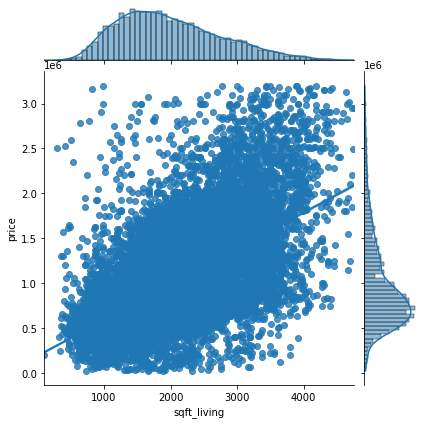

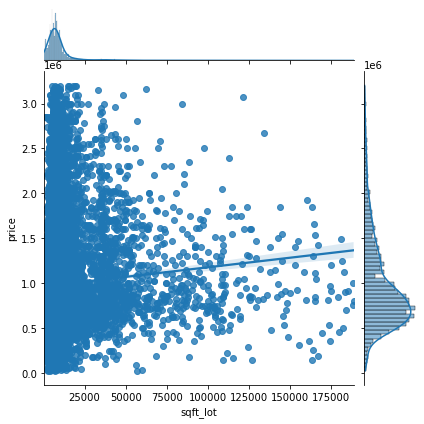

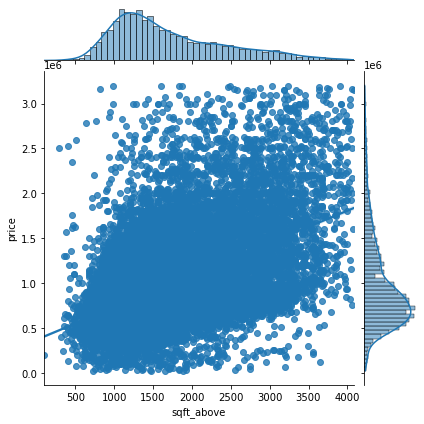

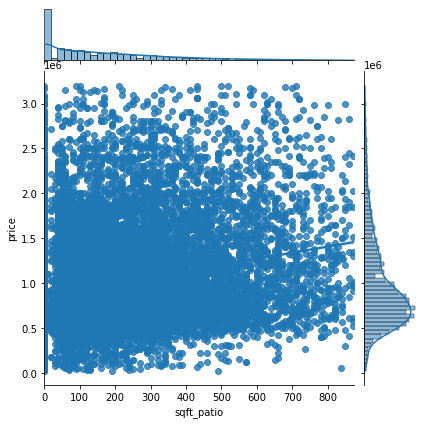

In [20]:
# We want to look at linearity of some select features vs our target variable, price
cont_feat = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_patio']


#  Plot jointplots
for feature in cont_feat:
    sns.jointplot(x = df[feature], y = df['price'], kind = 'reg')

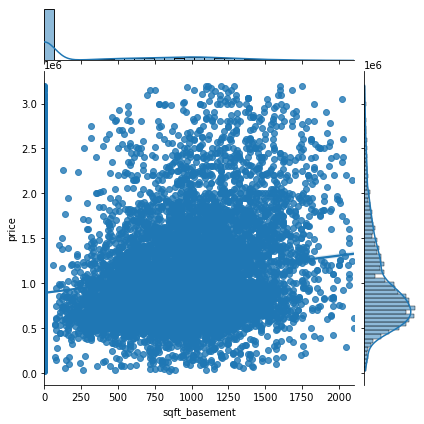

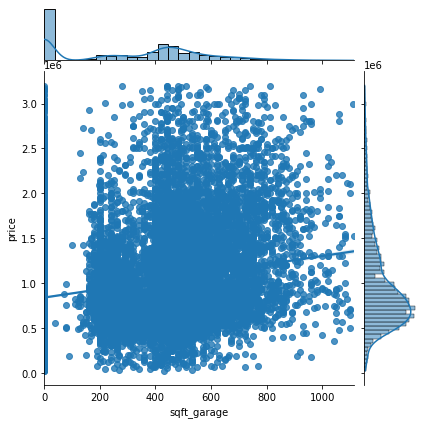

In [21]:
# let's look at linearity for some different continuous features

cont_feat_2 = ['sqft_basement', 'sqft_garage']


#  Plot jointplots
for feature in cont_feat_2:
    sns.jointplot(x = df[feature], y = df['price'], kind = 'reg')

In [22]:
# we're getting really screwed up data due to the zeroes in the basement sq foot. we are unsure whether to leave this
# column and calculate its mean, or create a new column of the mean with just those places that have a basement

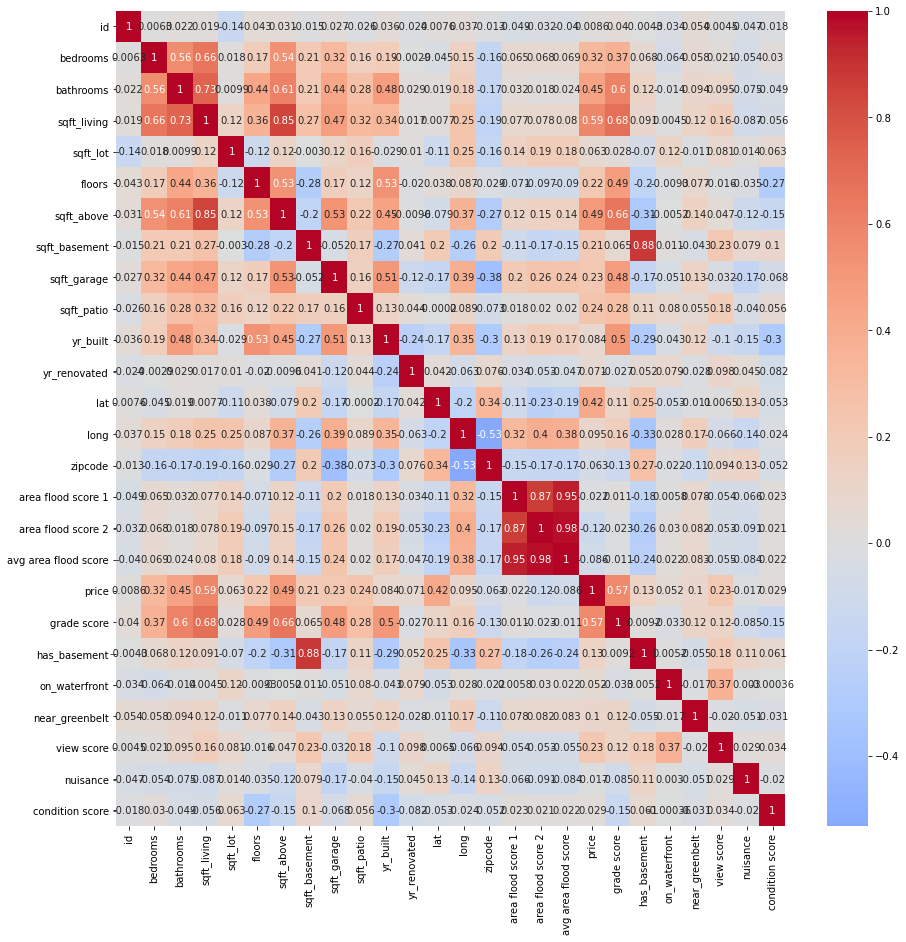

In [23]:
# done with continuous variables, so let's look again at multicollinearity using heatmaps

corr = df.corr()

# Plot heatmap
plt.figure(figsize = (15,15))
sns.heatmap(corr, center = 0, annot = True, cmap = 'coolwarm')
plt.show()

In [24]:
# gonna drop sq_basement, since it is so highly correlated with "has_basement" AND so few have basements that it
# really skews the mean

In [25]:
df.drop(labels='sqft_basement', axis=1, inplace=True)

In [30]:
# sqft_above is also fairly strongly correlated AND isn't super-relevant for our purposes
df.drop(labels='sqft_above', axis=1, inplace=True)

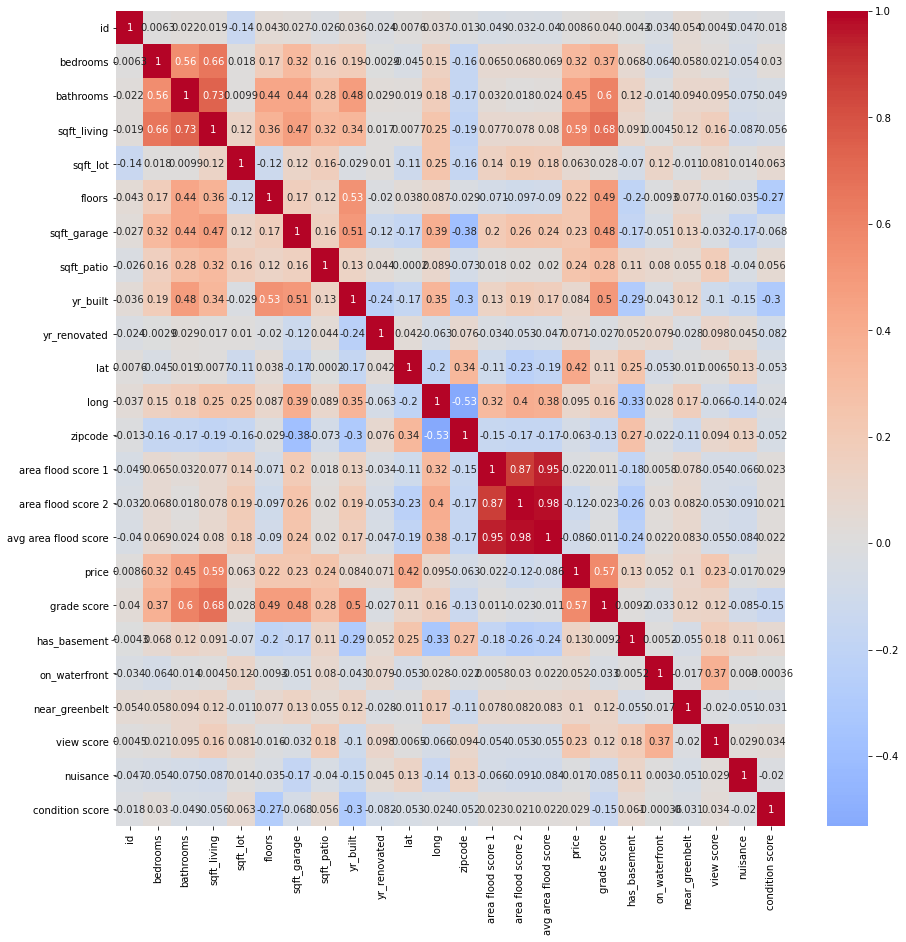

In [31]:
#let's get a new heatmap

new_corr = df.corr()

# Plot heatmap
plt.figure(figsize = (15,15))
sns.heatmap(new_corr, center = 0, annot = True, cmap = 'coolwarm')
plt.show()

In [43]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# https://www.statology.org/how-to-calculate-vif-in-python/

y, X = dmatrices('sqft_living ~ bedrooms+bathrooms', data=df, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

,VIF,variable
0,15.868828,Intercept
1,1.447613,bedrooms
2,1.447613,bathrooms


In [ ]:
# our VIF scores aren't bad (2-5 is moderate). let's try this again for a few other variables

In [38]:
df.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'heat_source', 'sewer_system', 'sqft_garage', 'sqft_patio',
       'yr_built', 'yr_renovated', 'lat', 'long', 'street address', 'city',
       'zipcode', 'floodzones in zipcode', 'area_flood_score_max',
       'area_flood_score_min', 'avg_area_flood_score', 'price', 'grade score',
       'has_basement', 'on_waterfront', 'near_greenbelt', 'view score',
       'nuisance', 'condition score'],
      dtype='object')

In [35]:
df.rename(columns={'area flood score 1': 'area_flood_score_max', 'area flood score 2':'area_flood_score_min', 
                   'avg area flood score':'avg_area_flood_score'}, inplace=True)

In [39]:
df.rename(columns={'floodzones in zipcode': 'floodzones_in_zipcode'}, inplace=True)

In [44]:
y, X = dmatrices('area_flood_score_max ~  area_flood_score_min+avg_area_flood_score', data=df, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

,VIF,variable
0,94.865676,Intercept
1,27.516518,area_flood_score_min
2,27.516518,avg_area_flood_score


In [ ]:
# very high VIF scores for our flood data, but should we drop? unsure how to handle
# overall, VIF scores are superior to correlation data, per https://online.stat.psu.edu/stat462/node/180/